In [118]:
import jax
import seaborn as sns
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
import pandas as pd

In [119]:
class Node():
    def __init__(self,name,value,probs,observed=False):
        self.name=name
        self.probs=probs
        self.parents=()
        self.children=()
        self.val=value
        self.observed=observed
        
    def add_parent(self,a):
        self.parents=(*self.parents,a)  
        
    def add_child(self,a):
        self.children=(*self.children,a)
        
    def __repr__(self):
        return self.name
    
    def __call__(self):
        if len(self.parents)==0:
            return 0
        values=list(map(lambda x:x.val,self.parents))
        prob=self.probs
        for val in values:
            prob=prob[val]
        return np.log(prob)

class BN():
    def __init__(self):
        self.varibles=()
        self.names=()
    def add(self,node):
        node.id=len(self.names)
        self.varibles=(*self.varibles,node)
        self.names=(*self.names,node.name)
        return self
    def add_edge(self,a,b):
        object_1=self.varibles[self.names.index(a)]
        object_2=self.varibles[self.names.index(b)]
        object_1.add_child(object_2)
        object_2.add_parent(object_1)
        return self
    def __repr__(self):
        string="0"
        return string
    
    def markov_blancket(self,id):
        object_id=self.varibles[id]
        blancket=[]
        blancket=[*blancket,*object_id.parents]
        blancket=[*blancket,*object_id.children]
        for object in object_id.children:
            for parent in object.parents:
                if parent not in blancket and parent is not object_id:
                    blancket.append(parent)
        return tuple(blancket)
    def propability(self,idd):
        return sum(tuple(map(lambda x:x(),self.markov_blancket(idd))))
        
    def gather(self):
        return np.array(list(map(lambda x:x.val,self.varibles)))
    
    def scatter(self,values):
        for node,val in zip(self.varibles,values):
            node.val=val
            
    def gibbs_sampling(self,num,num_burn=0,thin_out=1):
        values_to_choose=[]
        for i,node in enumerate(self.varibles):
            if not node.observed:
                values_to_choose.append(i)
        for _ in tqdm(range(num_burn),"burn in"):
            id=np.random.choice(values_to_choose)
            self.varibles[id].val=0
            prob_1=np.exp(self.propability(id))
            self.varibles[id].val=1
            prob_2=np.exp(self.propability(id))
            self.varibles[id].val=np.random.choice([0,1],p=[prob_1/(prob_1+prob_2),prob_2/(prob_1+prob_2)])
        values=np.zeros([0,len(values_to_choose)])
        for i in tqdm(range(num),"sampling"):
            id=np.random.choice(values_to_choose)
            self.varibles[id].val=0
            prob_1=np.exp(self.propability(id))
            self.varibles[id].val=1
            prob_2=np.exp(self.propability(id))
            self.varibles[id].val=np.random.choice([0,1],p=[prob_1/(prob_1+prob_2),prob_2/(prob_1+prob_2)])
            if i%thin_out==0:
                values=np.concatenate((values,self.gather()[values_to_choose].reshape(1,len(values_to_choose))))
        out=dict()
        for i,id,value in zip(range(len(values_to_choose)),values_to_choose,values):
            out[self.names[id]]=values[:,i]
        return out

In [120]:
net=BN()
rain=Node("rain",1,[0.2,0.8],False)
sprinkler=Node("sprinkler",1,[0.5,0.1],True)
cloud=Node("cloud",1,None,False)
grass=Node("wet grass",1,np.array([[0.01,0.9],[0.9,0.99]]),True)
net.add(rain).add(sprinkler).add(cloud).add(grass).add_edge("cloud","sprinkler").add_edge("cloud","rain").add_edge("rain","wet grass").add_edge("sprinkler","wet grass")

0

In [121]:
samples=net.gibbs_sampling(100000,10000,10)

sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 20104.54it/s]


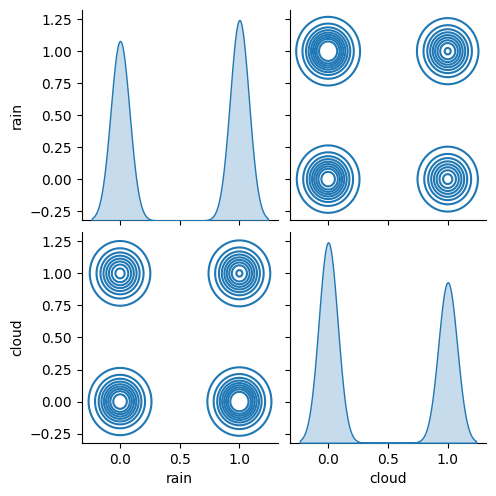

In [127]:
sns.pairplot(pd.DataFrame(samples),kind="kde")

In [123]:
net.varibles

(rain, sprinkler, cloud, wet grass)

In [124]:
samples

{'rain': array([0., 0., 0., ..., 1., 1., 1.]),
 'cloud': array([0., 0., 1., ..., 0., 0., 1.])}

In [125]:
a=np.array([[0.01,0.9],[0.9,0.99]])

In [126]:
np.mean(samples["rain"])

0.5275

In [129]:
a=np.zeros([10,10])

In [130]:
b=np.array([1,1])

In [131]:
a[b]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [132]:
a[b[0],b[1]]

0.0